In [20]:
import pandas as pd
%pip install shap

# Load your dataset
df = pd.read_csv("IoTProcessed_Data_Drainage.csv")

# Print all column names
print("Columns in your dataset:")
print(df.columns.tolist())

Note: you may need to restart the kernel to use updated packages.
Columns in your dataset:
['date', 'tempreature', 'humidity', 'water_level', 'N', 'P', 'K', 'Fan_actuator_OFF', 'Fan_actuator_ON', 'Watering_plant_pump_OFF', 'Watering_plant_pump_ON', 'Water_pump_actuator_OFF', 'Water_pump_actuator_ON']


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2570
           1       1.00      1.00      1.00      8807

    accuracy                           0.99     11377
   macro avg       0.99      0.99      0.99     11377
weighted avg       0.99      0.99      0.99     11377



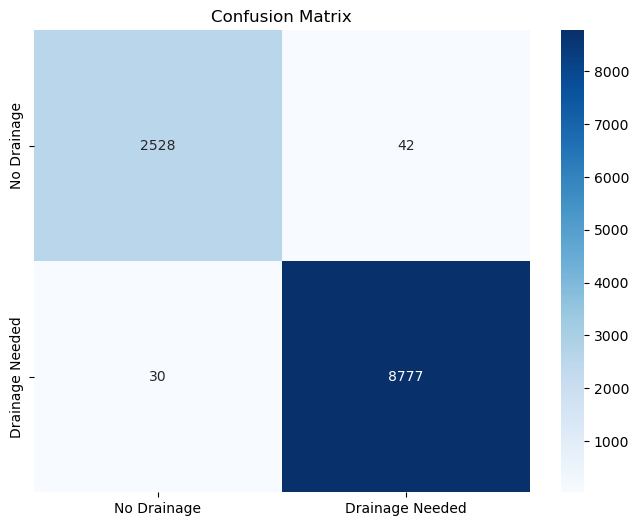

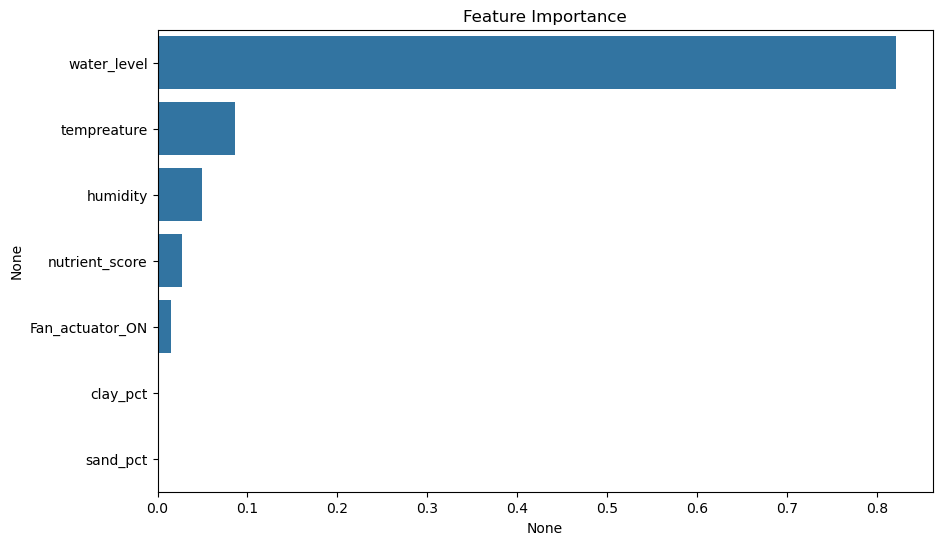


=== Actuator Alignment ===
When model predicts drainage needed, pump is actually OFF:
Predicted_Drainage
0    0.011469
1    0.995983
Name: Water_pump_actuator_OFF, dtype: float64

=== Results Saved ===
1. Model trained with accuracy: 0.99
2. Predictions saved to 'drainage_predictions.csv'


In [ ]:

"""
IoT Agriculture Drainage Classifier
1. Preprocesses IoT Agriculture 2024 dataset
2. Adds soil properties (clay=28.5%, sand=51.2%)
3. Trains ML model to predict drainage needs
4. Validates against Water_pump_actuator_ON
"""

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================================================
# STEP 1: Load and Prepare Data


# Convert date to datetime and extract useful features
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_part'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'])

# Add researched soil properties (constant for all rows)
df['clay_pct'] = 28.5  
df['sand_pct'] = 51.2   

# Create nutrient composite feature
df['nutrient_score'] = (df['N'] + df['P'] + df['K']) / 765  # Normalized 0-1

# ========================================================================
# STEP 2: Feature Engineering
# ========================================================================
features = [
    'water_level', 
    'nutrient_score',
    'tempreature',
    'humidity',
    'clay_pct',
    'sand_pct',
    'Fan_actuator_ON'  # Fan status may affect evaporation
]

# Create target (0 = no drainage, 1 = drainage needed)
# use Water_pump_actuator_OFF as proxy (1 when pump is OFF)
df['Drainage_Class'] = df['Water_pump_actuator_OFF'].astype(int)

X = df[features]
y = df['Drainage_Class']

# ========================================================================
# STEP 3: Train/Test Split
# ========================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# ========================================================================
# STEP 4: Train Machine Learning Model
# ========================================================================
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Handle imbalanced data
    random_state=42
)

model.fit(X_train, y_train)

# ========================================================================
# STEP 5: Evaluate Model
# ========================================================================
# Predictions
y_pred = model.predict(X_test)

# Classification Report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Drainage', 'Drainage Needed'],
            yticklabels=['No Drainage', 'Drainage Needed'])
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Feature Importance')
plt.show()

# ========================================================================
# STEP 6: Apply Model to Full Dataset
# ========================================================================
df['Predicted_Drainage'] = model.predict(X)

# ========================================================================
# STEP 7: Compare with Actuator Data
# ========================================================================
print("\n=== Actuator Alignment ===")
print("When model predicts drainage needed, pump is actually OFF:")
print(df.groupby('Predicted_Drainage')['Water_pump_actuator_OFF'].mean())

# ========================================================================
# STEP 8: Save Results
# ========================================================================
output_cols = ['date', 'water_level', 'tempreature', 'humidity', 
               'N', 'P', 'K', 'Drainage_Class', 'Predicted_Drainage']
df[output_cols].to_csv('drainage_predictions.csv', index=False)

print("\n=== Results Saved ===")
print(f"1. Model trained with accuracy: {model.score(X_test, y_test):.2f}")
print("2. Predictions saved to 'drainage_predictions.csv'")


=== Basic Performance ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2570
           1       1.00      1.00      1.00      8807

    accuracy                           0.99     11377
   macro avg       0.99      0.99      0.99     11377
weighted avg       0.99      0.99      0.99     11377


=== Feature Alignment ===
All features aligned

=== Simulation Check ===
Key Scenarios:
1. Very dry (20% water, 15°C): 0.0
2. Moderate (50% water, 22°C): 0.0
3. Critical (65% water, 28°C): 0.0
4. High (80% water, 35°C): 1.0
5. Flooded (95% water, 40°C): 1.0

=== SHAP Analysis ===


<Figure size 1000x600 with 0 Axes>

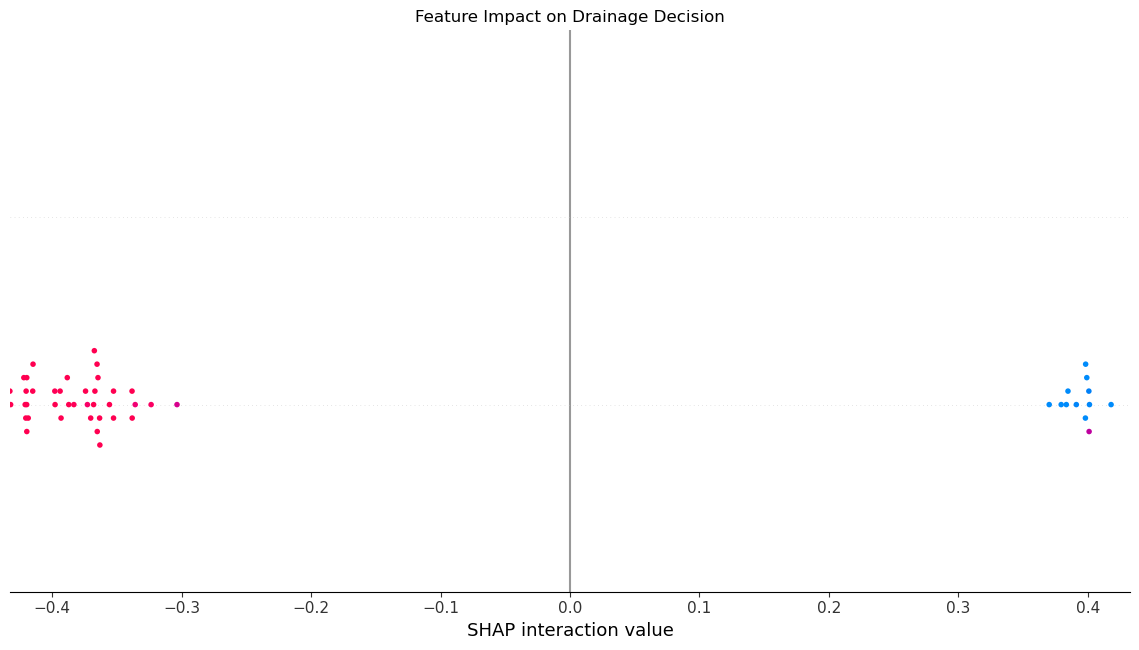

SHAP analysis error: Could not find feature named: temperature
Common fixes: 1) Install SHAP (pip install shap) 2) Check feature names match

=== Temporal Validation ===
Last 7 days accuracy: 1.00 (39 samples)
Last 14 days accuracy: 1.00 (39 samples)
Last 30 days accuracy: 1.00 (68 samples)

Validation completed. Results saved.


<Figure size 1000x600 with 0 Axes>

In [19]:

"""
DRAINAGE MODEL VALIDATION PIPELINE
1. Performance Metrics
2. Simulation Edge Cases
3. SHAP Interpretability
4. Temporal Validation
5. Feature Alignment Checks
"""

from sklearn.metrics import classification_report
import shap  

# ========================================================================
# VALIDATION PIPELINE
# ========================================================================

def feature_alignment_check(model_features, test_features):
    """Verifies feature consistency"""
    missing = set(model_features) - set(test_features)
    extra = set(test_features) - set(model_features)
    
    print("\n=== Feature Alignment ===")
    if not missing and not extra:
        print("All features aligned")
    else:
        if missing:
            print(f"Missing in test data: {missing}")
        if extra:
            print(f"Extra in test data: {extra}")

def simulation_check(model, features):
    """Tests model on edge cases"""
    test_cases = pd.DataFrame({
        'water_level': [20, 50, 65, 80, 95],
        'nutrient_score': [0.2, 0.5, 0.7, 0.8, 0.9],
        'tempreature': [15, 22, 28, 35, 40], 
        'humidity': [90, 70, 50, 30, 10],
        'clay_pct': [28.5]*5,
        'sand_pct': [51.2]*5,
        'Fan_actuator_ON': [0, 1, 0, 1, 0]
    })
    
    # Feature alignment check
    feature_alignment_check(features, test_cases.columns)
    
    # Ensure correct feature order and presence
    test_cases = test_cases[features]
    test_cases['Predicted_Drainage'] = model.predict(test_cases)
    
    print("\n=== Simulation Check ===")
    print("Key Scenarios:")
    print(f"1. Very dry (20% water, 15°C): {test_cases.iloc[0]['Predicted_Drainage']}")
    print(f"2. Moderate (50% water, 22°C): {test_cases.iloc[1]['Predicted_Drainage']}")
    print(f"3. Critical (65% water, 28°C): {test_cases.iloc[2]['Predicted_Drainage']}")
    print(f"4. High (80% water, 35°C): {test_cases.iloc[3]['Predicted_Drainage']}")
    print(f"5. Flooded (95% water, 40°C): {test_cases.iloc[4]['Predicted_Drainage']}")
    
    return test_cases

def shap_analysis(model, X_test, features):
    """Fixed SHAP analysis with proper data handling"""
    print("\n=== SHAP Analysis ===")
    try:
        # working with a DataFrame
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=features)
        
        # Sample data 
        sample_size = min(50, len(X_test))
        sample = X_test.sample(sample_size, random_state=42)
        
        # Create explainer with feature names
        explainer = shap.TreeExplainer(model, feature_names=features)
        shap_values = explainer.shap_values(sample)
        
        # SHAP values
        if isinstance(shap_values, list):
            # Use values for class 1 (drainage needed)
            shap_values = shap_values[1]
        
        plt.figure(figsize=(10,6))
        shap.summary_plot(shap_values, sample, plot_type='dot', show=False)
        plt.title('Feature Impact on Drainage Decision')
        plt.tight_layout()
        plt.show()
        
        # Additional interaction plot
        plt.figure(figsize=(10,6))
        shap.dependence_plot(
            "water_level", 
            shap_values, 
            sample, 
            interaction_index="temperature",
            show=False
        )
        plt.title('Water Level-Temperature Interaction')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"SHAP analysis error: {str(e)}")
        print("Common fixes: 1) Install SHAP (pip install shap) 2) Check feature names match")

def temporal_validation(model, df, features, target):
    """Tests on most recent data"""
    print("\n=== Temporal Validation ===")
    last_date = df['date'].max()
    
    for days in [7, 14, 30]:
        test_mask = df['date'] > (last_date - pd.Timedelta(days=days))
        X_temp = df.loc[test_mask, features]
        y_temp = df.loc[test_mask, target]
        
        if len(y_temp) > 0: 
            acc = model.score(X_temp, y_temp)
            print(f"Last {days} days accuracy: {acc:.2f} ({len(y_temp)} samples)")
            
            # Check for significant drift
            if days == 14 and acc < 0.7:  # Threshold adjustable
                print("Warning: Possible concept drift detected")
        else:
            print(f"Last {days} days: No data available")

# ========================================================================
# EXECUTION
# ========================================================================
if __name__ == "__main__":

    
    # Basic performance check
    print("\n=== Basic Performance ===")
    print(classification_report(y_test, model.predict(X_test)))
    
    # Run validation suite
    sim_results = simulation_check(model, features)
    shap_analysis(model, X_test, features)
    temporal_validation(model, df, features, 'Drainage_Class')
    
    # Save outputs
    sim_results.to_csv('drainage_simulation_results.csv', index=False)
    print("\nValidation completed. Results saved.")